In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import ast
from typing import Dict, List
from catboost import CatBoostClassifier
import json
from pandas import json_normalize
from tqdm import tqdm_notebook as tqdm
import catboost

In [2]:
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

In [3]:
events = pd.read_csv('../input/hackaton-ufc/data/0.events_raw.csv')
fighters = pd.read_csv('../input/hackaton-ufc/data/0.fighters_raw.csv')
fighters_cols = [
    "id",
    "name",
    "weight",
    "height",
    "armSpan",
    "legSwing",
    "weightCategory.id",
    "weight_category_name",
    "dateOfBirth",
    "country",
    "city",
    "timezone",
]

## Исследование данных о бойцах

In [4]:
fighters.head()

,Unnamed: 0,armSpan,avgFightTime,city,country,dateOfBirth,disciplines,draws,height,id,knockdownsPerFight,legSwing,looses,methods.looseMethods,methods.looseMethods.DEC,methods.looseMethods.DQ,methods.looseMethods.KO,methods.looseMethods.SUB,methods.winMethods,methods.winMethods.DEC,methods.winMethods.DQ,methods.winMethods.KO,methods.winMethods.SUB,name,photos,rank,sigStrikesAccuracy,significantStrikesDefendPercent,significantStrikesLandPerMinute,significantStrikesMissedPerMinute,submissionAttemptsPer15minutes,takedownsAccuracy,takedownsDefendPercent,takedownsPer15min,timezone,weight,weightCategory.id,weightCategory.name,wins
0,0,190.50,NaN,Bonnyville,Canada,1991-08-02,[],1,187.96,1,0.00,NaN,6,NaN,5.0,NaN,1.0,NaN,NaN,6.0,NaN,10.0,2.0,Tanner Boser,[{'url': 'http://bet2face.com/uploads/images/f...,16,49.0,63.0,4.17,3.23,NaN,NaN,100.0,NaN,America/Edmonton,115.67,9,Тяжелый вес,17
1,1,190.50,NaN,NaN,Brazil,1989-06-23,[],0,190.50,2,0.00,NaN,0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1.0,Giacomo Lemos,[{'url': 'http://bet2face.com/uploads/images/f...,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,America/Sao_Paulo,112.04,9,Тяжелый вес,6
2,2,193.04,11:41,Makhachkala,Dagestan,1981-09-02,[],0,190.50,3,0.21,105.41,5,NaN,1.0,NaN,3.0,1.0,NaN,7.0,NaN,9.0,3.0,Shamil Abdurakhimov,[{'url': 'http://bet2face.com/uploads/images/f...,16,44.0,58.0,2.45,2.45,0.2,24.0,47.0,1.23,Europe/Moscow,106.59,9,Тяжелый вес,20
3,3,187.96,15:00,Manaus,Brazil,1992-12-24,[],0,182.88,4,0.00,NaN,5,NaN,2.0,NaN,3.0,NaN,NaN,1.0,NaN,4.0,9.0,Klidson Abreu,[{'url': 'http://bet2face.com/uploads/images/f...,16,40.0,55.0,2.05,2.90,NaN,20.0,80.0,0.64,America/Manaus,92.99,8,Полутяжелый вес,15
4,4,190.50,13:05,Ikuno,Japan,1975-07-29,[],0,177.80,5,0.00,106.68,6,NaN,4.0,NaN,2.0,1.0,NaN,2.0,NaN,4.0,7.0,Yoshihiro Akiyama,[{'url': 'http://bet2face.com/uploads/images/f...,16,41.0,57.0,3.10,3.62,1.0,67.0,92.0,2.29,Asia/Tokyo,77.11,6,Полусредний вес,14


In [5]:
fighters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3669 entries, 0 to 3668
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3669 non-null   int64  
 1   armSpan                            1727 non-null   float64
 2   avgFightTime                       1738 non-null   object 
 3   city                               1361 non-null   object 
 4   country                            2458 non-null   object 
 5   dateOfBirth                        3599 non-null   object 
 6   disciplines                        3669 non-null   object 
 7   draws                              3669 non-null   int64  
 8   height                             3335 non-null   float64
 9   id                                 3669 non-null   int64  
 10  knockdownsPerFight                 1937 non-null   float64
 11  legSwing                           774 non-null    float

In [6]:
# Есть ли дубликаты
fighters.duplicated().sum()

0

In [7]:
# Переведем dateOfBirth в datetime
fighters['dateOfBirth'] = pd.to_datetime(fighters["dateOfBirth"])

In [8]:
# Посмотрим из каких стран бойцы
fighters['country'].unique()

array(['Canada', 'Brazil', 'Dagestan', 'Japan', 'Mexico', 'United States',
       'Nigeria', 'Germany', 'Sweden', nan, 'Russia', 'England', 'Spain',
       'Minnesota', 'Iraq', 'Texas', 'Australia', 'Iowa', 'France',
       'California', 'Peru', 'Afghanistan', 'Jamaica', 'China',
       'New York', 'New Jersey', 'Ecuador', 'Italy', 'Poland',
       'Dominican Republic', 'Scotland', 'Philippines', 'Syria',
       'Ireland', 'Georgia', 'Virginia', 'New Zealand',
       'Democratic Republic of Congo', 'Brasil', 'Bulgaria',
       'Northern Mariana Islands', 'Missouri', 'South Korea', 'Argentina',
       'Iran', 'Ukraine', 'Moldova', 'Wisconsin', 'Cuba', 'Colombia',
       'Wales', 'Venezuela', 'Arkansas', 'Cameroon', 'Soviet Union',
       'Switzerland', 'Colorado', 'Finland', 'Belarus', 'Illinois',
       'Florida', 'Michigan', 'United Kingdom', 'Czech Republic',
       'Austria', 'Massachusetts', 'Suriname', 'Netherlands', 'Belgium',
       'Serbia', 'Washington', 'Lithuania', 'Hawaii',

In [9]:
len(fighters['country'].unique())

153

Найденные ошибки в странах:

Штаты и United States заменить на USA, Дагестан - это Россия, Wales - Великобритания, есть Советский Союз, есть England и United Kingdom, Saint Pierre and Miquelon - Франция, 'Los Angeles', 'Saint Louis' - USA, Ontario - Канада, Ukrainian SSR и Ukraine, Floirda - США, Rostov-On-Don - Россия, Califorina- USA, Democratic Republic of Congo/Democratic Republic Of The Congo/Republic of Congo, Bosnia/Bosnia Herzegovina, Armenian SSR/Armenia, Colombia/ British Columbia, Quebec - Канада

Исправим то, что нашли

In [10]:
usa_state_names = [
    "Alaska",
    "Alabama",
    "Arkansas",
    "American Samoa",
    "Arizona",
    "California",
    "Colorado",
    "Connecticut",
    "District ",
    "of Columbia",
    "Delaware",
    "Florida",
    "Floirda"
    "Georgia",
    "Guam",
    "Hawaii",
    "Iowa",
    "Idaho",
    "Illinois",
    "Indiana",
    "Kansas",
    "Kentucky",
    "Louisiana",
    "Saint Louis",
    "Los Angeles"
    "Massachusetts",
    "Maryland",
    "Maine",
    "Michigan",
    "Minnesota",
    "Missouri",
    "Mississippi",
    "Montana",
    "North Carolina",
    "North Dakota",
    "Nebraska",
    "New Hampshire",
    "New Jersey",
    "New Mexico",
    "Nevada",
    "New York",
    "Ohio",
    "Oklahoma",
    "Oregon",
    "Pennsylvania",
    "Puerto Rico",
    "Rhode Island",
    "South Carolina",
    "South Dakota",
    "Tennessee",
    "Texas",
    "Utah",
    "Virginia",
    "Virgin Islands",
    "Vermont",
    "Washington",
    "Wisconsin",
    "West Virginia",
    "Wyoming",
    "Massachusetts"
    
    
]


In [11]:
fighters.loc[fighters['country'] == 'United States', 'country'] = 'USA'
fighters.loc[fighters['country'].isin(usa_state_names), 'country'] = 'USA'


len(fighters['country'].unique())

116

In [12]:
fighters.loc[fighters['country'] == 'Dagestan', 'country'] = 'Russia'
fighters.loc[fighters['country'] == 'Rostov-On-Don', 'country'] = 'Russia'
fighters.loc[fighters['country'] == 'Wales', 'country'] = 'United Kingdom'
fighters.loc[fighters['country'] == 'England', 'country'] = 'United Kingdom'
fighters.loc[fighters['country'] == 'Saint Pierre and Miquelon', 'country'] = 'France'
fighters.loc[fighters['country'] == 'Ontario', 'country'] = 'Canada'
fighters.loc[fighters['country'] == 'Quebec', 'country'] = 'Canada'
fighters.loc[fighters['country'] == 'Ukrainian SSR', 'country'] = 'Soviet Union'
fighters.loc[fighters['country'] == 'Democratic Republic Of The Congo', 'country'] = 'Democratic Republic of Congo'
fighters.loc[fighters['country'] == 'Republic of Congo', 'country'] = 'Democratic Republic of Congo'
fighters.loc[fighters['country'] == 'Bosnia Herzegovina', 'country'] = 'Bosnia'
fighters.loc[fighters['country'] == 'Armenian SSR', 'country'] = 'Soviet Union'
fighters.loc[fighters['country'] == 'British Columbia', 'country'] = 'Colombia'
fighters.loc[fighters['country'] == 'Holland', 'country'] = 'Netherlands'


In [13]:
len(fighters['country'].unique())

102

In [14]:
fighters['country'].unique()

array(['Canada', 'Brazil', 'Russia', 'Japan', 'Mexico', 'USA', 'Nigeria',
       'Germany', 'Sweden', nan, 'United Kingdom', 'Spain', 'Iraq',
       'Australia', 'France', 'Peru', 'Afghanistan', 'Jamaica', 'China',
       'Ecuador', 'Italy', 'Poland', 'Dominican Republic', 'Scotland',
       'Philippines', 'Syria', 'Ireland', 'Georgia', 'New Zealand',
       'Democratic Republic of Congo', 'Brasil', 'Bulgaria',
       'Northern Mariana Islands', 'South Korea', 'Argentina', 'Iran',
       'Ukraine', 'Moldova', 'Cuba', 'Colombia', 'Venezuela', 'Cameroon',
       'Soviet Union', 'Switzerland', 'Finland', 'Belarus',
       'Czech Republic', 'Austria', 'Suriname', 'Netherlands', 'Belgium',
       'Serbia', 'Lithuania', 'Bosnia', 'Azerbaijan', 'Latvia',
       'Kazakhstan', 'Iceland', 'Romania', 'South Africa', 'Costa Rica',
       'Denmark', 'Chile', 'Espirito Santo Brazil', 'Kyrgyzstan',
       'Armenia', 'Macedonia', 'Hungary', 'Tasmania', 'Cyprus', 'Croatia',
       'Bahamas', 'Califorin

In [15]:
fighters.describe()


,Unnamed: 0,armSpan,draws,height,id,knockdownsPerFight,legSwing,looses,methods.looseMethods.DEC,methods.looseMethods.DQ,methods.looseMethods.KO,methods.looseMethods.SUB,methods.winMethods.DEC,methods.winMethods.DQ,methods.winMethods.KO,methods.winMethods.SUB,rank,sigStrikesAccuracy,significantStrikesDefendPercent,significantStrikesLandPerMinute,significantStrikesMissedPerMinute,submissionAttemptsPer15minutes,takedownsAccuracy,takedownsDefendPercent,takedownsPer15min,weight,weightCategory.id,wins
count,3669.000000,1727.000000,3669.000000,3335.000000,3669.000000,1937.000000,774.000000,3669.000000,2148.000000,21.0,2141.000000,1870.000000,2162.000000,20.000000,2285.000000,2189.000000,3669.000000,2685.000000,2745.000000,2686.000000,2750.000000,1439.000000,1881.000000,2086.000000,1882.000000,3530.000000,3669.00000,3669.000000
mean,1834.000000,182.566925,0.261924,178.680006,1840.017443,0.271182,101.829238,4.921777,3.144320,1.0,2.531060,2.507487,4.551804,1.050000,5.268271,5.618090,15.965658,42.995903,52.226594,2.842651,3.615407,1.513586,46.839447,61.162033,2.163587,78.472513,7.30199,11.216135
std,1059.293397,12.444285,0.816489,9.924185,1062.215404,0.761949,7.562750,4.605558,2.591525,0.0,2.075579,2.774897,3.597566,0.223607,4.341817,5.509868,0.626059,12.848582,12.590417,1.794512,2.727638,2.087365,24.202004,22.783532,2.067852,18.186395,3.12400,8.611220
min,0.000000,152.400000,0.000000,152.400000,1.000000,0.000000,39.000000,0.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,4.000000,0.060000,0.130000,0.100000,4.000000,5.000000,0.080000,47.630000,2.00000,0.000000
25%,917.000000,175.260000,0.000000,172.720000,922.000000,0.000000,96.520000,2.000000,1.000000,1.0,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,16.000000,35.000000,45.000000,1.620000,2.200000,0.500000,30.000000,46.000000,0.940000,65.770000,5.00000,6.000000
50%,1834.000000,182.880000,0.000000,177.800000,1839.000000,0.000000,101.600000,4.000000,2.000000,1.0,2.000000,2.000000,4.000000,1.000000,4.000000,4.000000,16.000000,42.000000,54.000000,2.610000,3.080000,0.900000,42.000000,61.000000,1.690000,77.110000,7.00000,10.000000
75%,2751.000000,190.500000,0.000000,185.420000,2760.000000,0.370000,106.680000,7.000000,4.000000,1.0,3.000000,3.000000,6.000000,1.000000,7.000000,7.000000,16.000000,50.000000,60.000000,3.670000,4.277500,1.700000,57.000000,77.000000,2.800000,83.910000,9.00000,15.000000
max,3668.000000,458.470000,11.000000,445.260000,3677.000000,19.570000,200.660000,74.000000,20.000000,1.0,27.000000,51.000000,30.000000,2.000000,83.000000,127.000000,16.000000,100.000000,100.000000,23.410000,52.500000,21.900000,100.000000,100.000000,32.140000,349.270000,14.00000,127.000000


## Посмотрим на выбросы в параметрах тела

In [16]:
fighters['armSpan'].describe()

count    1727.000000
mean      182.566925
std        12.444285
min       152.400000
25%       175.260000
50%       182.880000
75%       190.500000
max       458.470000
Name: armSpan, dtype: float64

<AxesSubplot:>

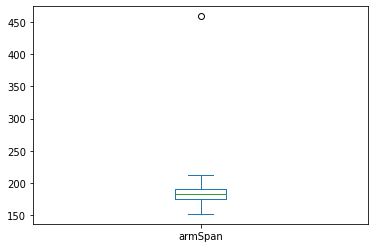

In [17]:
fighters['armSpan'].plot.box()

In [18]:
fighters[fighters['armSpan'] > 210]['armSpan'].count()

6

In [19]:
fighters[fighters['armSpan'] > 210]['armSpan']

121     213.36
255     210.82
258     210.82
535     213.36
674     213.36
3405    458.47
Name: armSpan, dtype: float64

In [20]:
# Удалим этот выброс
fighters.drop(index=3405, inplace=True)

In [21]:
# Проверка
fighters[fighters['armSpan'] > 400]['armSpan']

Series([], Name: armSpan, dtype: float64)

In [22]:
fighters['legSwing'].describe()

count    773.000000
mean     101.910517
std        7.221447
min       81.280000
25%       96.520000
50%      101.600000
75%      106.680000
max      200.660000
Name: legSwing, dtype: float64

<AxesSubplot:>

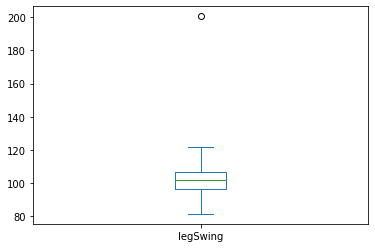

In [23]:
fighters['legSwing'].plot.box()

In [24]:
fighters[fighters['legSwing'] < 85]['legSwing']

481    81.28
569    83.82
Name: legSwing, dtype: float64

In [25]:
fighters[fighters['legSwing'] > 120]['legSwing']

535    121.92
603    200.66
710    121.92
752    121.92
Name: legSwing, dtype: float64

In [26]:
fighters['height'].describe()

count    3334.000000
mean      178.600048
std         8.785841
min       152.400000
25%       172.720000
50%       177.800000
75%       185.420000
max       226.060000
Name: height, dtype: float64

<AxesSubplot:>

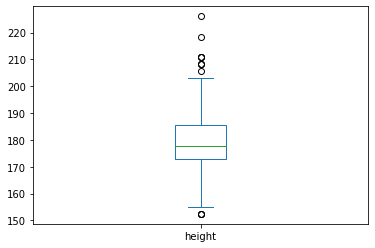

In [27]:
fighters['height'].plot.box()

In [28]:
fighters[fighters['height'] > 220]['height']

3132    226.06
Name: height, dtype: float64

In [29]:
fighters[fighters['height'] < 154]['height']

63      152.4
569     152.4
2239    152.4
Name: height, dtype: float64

In [30]:
fighters['weight'].describe()

count    3530.000000
mean       78.472513
std        18.186395
min        47.630000
25%        65.770000
50%        77.110000
75%        83.910000
max       349.270000
Name: weight, dtype: float64

<AxesSubplot:>

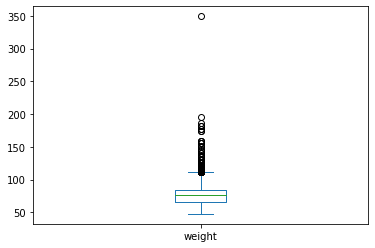

In [31]:
fighters['weight'].plot.box()

In [32]:
fighters[fighters['weight'] < 52]['weight']

2026    51.26
2348    51.26
3023    47.63
3199    47.63
Name: weight, dtype: float64

In [33]:
fighters[fighters['weight'] > 200]['weight']

1904    349.27
Name: weight, dtype: float64

In [34]:
# Удалим этот выброс
fighters.drop(index=1904, inplace=True)

In [35]:
# Проверка
fighters[fighters['weight'] > 200]['weight']

Series([], Name: weight, dtype: float64)

## Посмотрим на количество нулевых значений в параметрах тела

In [36]:
fighters['weight'].isnull().sum() 

138

In [37]:
fighters['height'].isnull().sum()

334

In [38]:
fighters['legSwing'].isnull().sum()

2894

In [39]:
fighters['armSpan'].isnull().sum()

1941

In [40]:
fighters['id'].count()

3667

## Заменим пропуски в параметрах тела на средние значения по весовым категорям

In [41]:
groupNames = fighters['weightCategory.name'].unique()
groupNames

array(['Тяжелый вес', 'Полутяжелый вес', 'Полусредний вес',
       'Женский минимальный вес', 'Средний вес', 'Женский легчайший вес',
       'Полулегкий вес', 'Легкий вес', 'Легчайший вес',
       'Женский полулегкий вес', 'Наилегчайший вес',
       'Женский наилегчайший вес', 'Не определена'], dtype=object)

In [42]:
median_armSpan = fighters.groupby(['weightCategory.name']).median()['armSpan']

for name in groupNames:
    fighters.loc[ (fighters['weightCategory.name']==name) & 
                 (fighters['armSpan'].isnull()), 
                 'armSpan'] = median_armSpan[name]

In [43]:
fighters['armSpan'].isnull().sum()

0

In [44]:
median_legSwing = fighters.groupby(['weightCategory.name']).median()['legSwing']

for name in groupNames:
    fighters.loc[ (fighters['weightCategory.name']==name) & 
                 (fighters['legSwing'].isnull()), 
                 'legSwing'] = median_legSwing[name]

In [45]:
fighters['legSwing'].isnull().sum()

0

In [46]:
median_height = fighters.groupby(['weightCategory.name']).median()['height']

for name in groupNames:
    fighters.loc[ (fighters['weightCategory.name']==name) & 
                 (fighters['height'].isnull()), 
                 'height'] = median_height[name]

In [47]:
fighters['height'].isnull().sum()

0

In [48]:
meadian_weight = fighters.groupby(['weightCategory.name']).median()['weight']

for name in groupNames:
    fighters.loc[ (fighters['weightCategory.name']==name) & 
                 (fighters['weight'].isnull()), 
                 'weight'] = meadian_weight[name]

In [49]:
fighters['weight'].isnull().sum()

0

## Переведем среднее время боя в секунды

In [50]:
def fightTimeToSeconds(x):
    if pd.isnull(x):
        return 0
    else:
        return int(x[0:2]) * 60 + int(x[3:5])

fighters['avgFightTime'] = fighters['avgFightTime'].apply(lambda x: fightTimeToSeconds(x))

In [51]:
fighters['avgFightTime'].head()

0      0
1      0
2    701
3    900
4    785
Name: avgFightTime, dtype: int64

In [52]:
fighters.describe()

,Unnamed: 0,armSpan,avgFightTime,draws,height,id,knockdownsPerFight,legSwing,looses,methods.looseMethods.DEC,methods.looseMethods.DQ,methods.looseMethods.KO,methods.looseMethods.SUB,methods.winMethods.DEC,methods.winMethods.DQ,methods.winMethods.KO,methods.winMethods.SUB,rank,sigStrikesAccuracy,significantStrikesDefendPercent,significantStrikesLandPerMinute,significantStrikesMissedPerMinute,submissionAttemptsPer15minutes,takedownsAccuracy,takedownsDefendPercent,takedownsPer15min,weight,weightCategory.id,wins
count,3667.000000,3667.000000,3667.000000,3667.000000,3667.000000,3667.000000,1935.000000,3667.000000,3667.000000,2148.000000,21.0,2139.000000,1869.000000,2162.000000,20.000000,2285.000000,2187.000000,3667.000000,2685.000000,2745.000000,2686.000000,2750.000000,1439.000000,1881.000000,2086.000000,1882.000000,3667.000000,3667.000000,3667.000000
mean,1833.552495,184.354082,269.902100,0.262067,178.667314,1839.569403,0.271463,104.122164,4.923371,3.144320,1.0,2.532492,2.508293,4.551804,1.050000,5.268271,5.622314,15.965639,42.995903,52.226594,2.842651,3.615407,1.513586,46.839447,61.162033,2.163587,78.311287,7.298337,11.219798
std,1059.263851,8.781502,330.062143,0.816689,8.485560,1062.186345,0.762293,5.100766,4.606308,2.591525,0.0,2.076021,2.775420,3.597566,0.223607,4.341817,5.510617,0.626229,12.848582,12.590417,1.794512,2.727638,2.087365,24.202004,22.783532,2.067852,17.332805,3.120931,8.611751
min,0.000000,152.400000,0.000000,0.000000,152.400000,1.000000,0.000000,81.280000,0.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,4.000000,0.060000,0.130000,0.100000,4.000000,5.000000,0.080000,47.630000,2.000000,0.000000
25%,916.500000,177.800000,0.000000,0.000000,172.720000,921.500000,0.000000,99.060000,2.000000,1.000000,1.0,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,16.000000,35.000000,45.000000,1.620000,2.200000,0.500000,30.000000,46.000000,0.940000,65.770000,5.000000,6.000000
50%,1833.000000,185.420000,0.000000,0.000000,180.340000,1838.000000,0.000000,105.410000,4.000000,2.000000,1.0,2.000000,2.000000,4.000000,1.000000,4.000000,4.000000,16.000000,42.000000,54.000000,2.610000,3.080000,0.900000,42.000000,61.000000,1.690000,77.110000,7.000000,10.000000
75%,2750.500000,190.500000,576.500000,0.000000,185.420000,2759.500000,0.370000,107.950000,7.000000,4.000000,1.0,3.000000,3.000000,6.000000,1.000000,7.000000,7.000000,16.000000,50.000000,60.000000,3.670000,4.277500,1.700000,57.000000,77.000000,2.800000,83.910000,9.000000,15.000000
max,3668.000000,213.360000,1200.000000,11.000000,226.060000,3677.000000,19.570000,200.660000,74.000000,20.000000,1.0,27.000000,51.000000,30.000000,2.000000,83.000000,127.000000,16.000000,100.000000,100.000000,23.410000,52.500000,21.900000,100.000000,100.000000,32.140000,195.040000,14.000000,127.000000


## Терминология

https://ufc.ru/intro-to-mma

armSpan Arm span or reach (sometimes referred to as wingspan, or spelled "armspan") is the physical measurement of the length from one end of an individual's arms (measured at the fingertips) to the other when raised parallel to the ground at shoulder height at a 90° angle.

legSwing размах ноги

Draw ничья

significantStrikesMissedPerMinute Значительные удары Significant Strikes are basically any strike that significantly improves your chance of winning the fight. That basically boils down to any strike thrown to the legs, body, or head with enough force to be considered damaging.

Judges' Decision (U-Dec, S-Dec):
When a fight is not finished by a submission, KO, or TKO, the judges deliver their scorecards for a final decision. 


Нокаут ( англ. КО ) : боец оказывается в бессознательном состоянии в результате одного или нескольких точных ударов из положения стоя, после которого (ых) бой немедленно остановлен рефери, без возможности добивания соперника на земле.



Технический нокаут (англ. TKO): остановка боя третьим лицом в результате потери одним из бойцов способности продолжать бой. Технические нокауты могут подразделяться на три категории:

Остановка рефери (англ. Referee stoppage). Рефери решает, что один из бойцов не может осмысленно защищаться, и останавливает бой.

Остановка врачом (врач, присутствующий возле ринга, решает, что дальнейшее участие одного из бойцов ставит жизнь или здоровье этого участника под угрозу. Например, травмы или обильное кровотечение)

Остановка «углом» (англ. Corner stoppage). Угловой секундант бойца сигнализирует об остановке боя.

DQ - дисквалификация. Использование запрещённого приема в поединке.
Болевые и удушающие относятся к ТКО, то есть это добровольная сдача бойца или остановка боя арбитром.

Submission (SUB): 
Physical or verbal tap out by one of dozens of methods of submission. 

In [53]:
# Посмотрим на столбец disciplines
fighters['disciplines'].unique()

array(['[]'], dtype=object)

In [54]:
# Узнаем названия весовых категорий
fighters['weightCategory.name'].unique()

array(['Тяжелый вес', 'Полутяжелый вес', 'Полусредний вес',
       'Женский минимальный вес', 'Средний вес', 'Женский легчайший вес',
       'Полулегкий вес', 'Легкий вес', 'Легчайший вес',
       'Женский полулегкий вес', 'Наилегчайший вес',
       'Женский наилегчайший вес', 'Не определена'], dtype=object)

Наилегчайший вес — от 53 до 57 килограммов.
Легчайший вес — от 57 до 61кг
Полулёгкий вес — от 61 до 66кг
Лёгкий вес — от 66 до 70кг
Полусредний вес — от 70 до 77кг
Средний вес — от 77 до 84 кг
Полутяжёлый вес — от 84 до 94 кг
Тяжёлый вес — от 93 до 120кг

Женский минимальный вес (Strawweight) — до 115 фунтов (52 кг);
Наилегчайший вес (Flyweight) — до 125 фунтов (57 кг);
Легчайший вес (Bantamweight) — до 135 фунтов (61 кг);
Полулёгкий вес (Bantamweight) — до 145 фунтов (66 кг).

In [55]:
# Посмотрим имена категорий веса по id
weight_id_name = fighters.loc[:,['weightCategory.id', 'weightCategory.name']]
weight_id_name.drop_duplicates().sort_values(by=['weightCategory.id'])

,weightCategory.id,weightCategory.name
44,2,Наилегчайший вес
19,3,Легчайший вес
16,4,Полулегкий вес
17,5,Легкий вес
4,6,Полусредний вес
7,7,Средний вес
3,8,Полутяжелый вес
0,9,Тяжелый вес
5,10,Женский минимальный вес
65,11,Женский наилегчайший вес


In [56]:
# Среднее значение по весовой категории
fighters.groupby(by='weightCategory.id').mean()['weight']

weightCategory.id
2      57.046412
3      61.131341
4      64.170935
5      70.399448
6      72.172220
7      80.681747
8      92.214781
9     108.324620
10     52.421250
11     56.808095
12     61.133721
13     63.253333
14     85.860239
Name: weight, dtype: float64

In [57]:
# Количество бойцов в каждой весовой категории
fighters['weightCategory.name'].value_counts()

Средний вес                 853
Полулегкий вес              588
Полусредний вес             545
Не определена               418
Полутяжелый вес             389
Тяжелый вес                 342
Легкий вес                  145
Наилегчайший вес            131
Легчайший вес                82
Женский минимальный вес      80
Женский легчайший вес        43
Женский наилегчайший вес     42
Женский полулегкий вес        9
Name: weightCategory.name, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


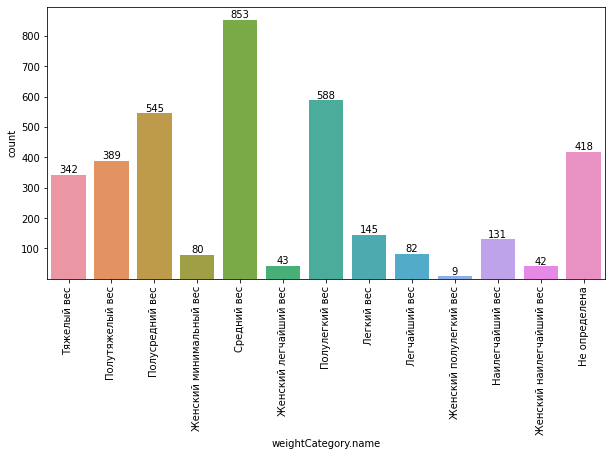

In [58]:
# График количество бойцов в каждой весовой категории
plt.figure(figsize=(10,5))
bar = sns.countplot(fighters['weightCategory.name'])
plt.xticks(rotation=90)
ax = plt.gca()
y_max = fighters['weightCategory.name'].value_counts().max() 
ax.set_ylim(1)
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), p.get_height(), 
        fontsize=10, color='black', ha='center', va='bottom')   
plt.show();

In [59]:
new_f = fighters
new_f.rename(columns={'weightCategory.name': 'weight_category_name'}, inplace=True)
women = new_f.weight_category_name.str.contains('Жен')

women1 = len(new_f[women])
men = (len(new_f['weight_category_name'])) - len(new_f[women])

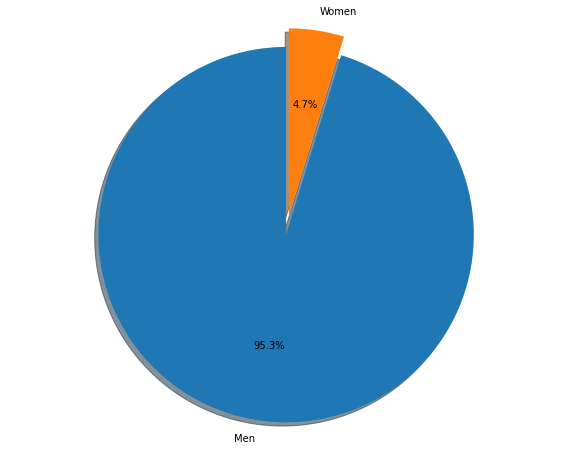

In [60]:
# Соотношение мужчин и женщин среди борцов
labels = 'Men', 'Women'
sizes = [men,women1]
explode = (0, 0.1,)  

fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90 )
ax1.axis('equal') 

plt.show()

In [61]:
# Количество бойцов по странам
(fighters
 .pivot_table(index='country', values='id', aggfunc='count')
 .sort_values('id', ascending=False)).head(50)

,id
country,
USA,1389
Brazil,304
Japan,104
Canada,86
United Kingdom,74
Russia,61
Australia,37
Mexico,28
France,27


In [62]:
 # Посмотрим на столбец methods.winMethods
fighters['methods.winMethods'].unique()

array([nan, '[]'], dtype=object)

In [63]:
# Посмотрим из каких стран больше всего победителей
(fighters
 .pivot_table(index='country', values='wins', aggfunc='sum')
 .sort_values('wins', ascending=False)).head(50)

,wins
country,
USA,17095
Brazil,4304
Japan,1824
Canada,1097
United Kingdom,991
Russia,977
Australia,410
Poland,407
France,376


# Исследование данных о боях

In [64]:
events.head()

,Unnamed: 0,avgOdds,city,completed,country,duration,eventDate.date,eventDate.timezone,eventDate.timezone_type,fighterId_1,fighterId_2,fighters,id,link,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId
0,0,[],Denver,True,USA,104.0,1993-11-12 00:00:00.000000,Europe/Berlin,3,1646,1923,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",5201,http://www.ufcstats.com/fight-details/64139d1d...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0
1,0,[],Denver,True,USA,52.0,1993-11-12 00:00:00.000000,Europe/Berlin,3,1777,1883,"[{'fighterId': 1777, 'fightStats': {'hitsTotal...",5202,http://www.ufcstats.com/fight-details/00b07967...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0
2,0,[],Denver,True,USA,59.0,1993-11-12 00:00:00.000000,Europe/Berlin,3,1908,1923,"[{'fighterId': 1908, 'fightStats': {'hitsTotal...",5203,http://www.ufcstats.com/fight-details/ac7ca2ec...,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0
3,0,[],Denver,True,USA,57.0,1993-11-12 00:00:00.000000,Europe/Berlin,3,1631,1646,"[{'fighterId': 1631, 'fightStats': {'hitsTotal...",5204,http://www.ufcstats.com/fight-details/ffd16691...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0
4,0,[],Denver,True,USA,138.0,1993-11-12 00:00:00.000000,Europe/Berlin,3,1646,1924,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",5205,http://www.ufcstats.com/fight-details/cecdc0da...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0


In [65]:
events.columns

Index(['Unnamed: 0', 'avgOdds', 'city', 'completed', 'country', 'duration',
       'eventDate.date', 'eventDate.timezone', 'eventDate.timezone_type',
       'fighterId_1', 'fighterId_2', 'fighters', 'id', 'link', 'name',
       'rounds', 'timezone', 'weightCategory.id', 'weightCategory.name',
       'winMethods', 'winnerId'],
      dtype='object')

In [66]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7100 entries, 0 to 7099
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               7100 non-null   int64  
 1   avgOdds                  7100 non-null   object 
 2   city                     7061 non-null   object 
 3   completed                7100 non-null   bool   
 4   country                  7064 non-null   object 
 5   duration                 6942 non-null   float64
 6   eventDate.date           7100 non-null   object 
 7   eventDate.timezone       7100 non-null   object 
 8   eventDate.timezone_type  7100 non-null   int64  
 9   fighterId_1              7100 non-null   int64  
 10  fighterId_2              7100 non-null   int64  
 11  fighters                 7100 non-null   object 
 12  id                       7100 non-null   int64  
 13  link                     7100 non-null   object 
 14  name                    

Пропуски в city, country, duration, rounds, timezone, winnerId

In [67]:
events.describe()

,Unnamed: 0,duration,eventDate.timezone_type,fighterId_1,fighterId_2,id,rounds,weightCategory.id,winnerId
count,7100.0,6942.000000,7100.0,7100.000000,7100.000000,7100.000000,6942.000000,7100.000000,6955.000000
mean,0.0,226.859407,3.0,736.403099,1306.382676,7108.068732,2.228464,6.630845,895.050036
std,0.0,108.925905,0.0,673.284964,889.793592,11523.657232,1.012646,2.825174,783.947505
min,0.0,2.000000,3.0,1.000000,16.000000,1.000000,1.000000,2.000000,0.000000
25%,0.0,142.250000,3.0,223.000000,591.000000,1775.750000,1.000000,5.000000,335.000000
50%,0.0,280.000000,3.0,514.000000,1092.000000,3550.500000,2.000000,6.000000,632.000000
75%,0.0,300.000000,3.0,1064.000000,1697.000000,5329.250000,3.000000,8.000000,1258.000000
max,0.0,1994.000000,3.0,3610.000000,3677.000000,40508.000000,5.000000,14.000000,3666.000000


In [68]:
# Переведем eventDate.date в datetime
events['eventDate.date'] = pd.to_datetime(events['eventDate.date'])

In [69]:
events['eventDate.date'].head()

0   1993-11-12
1   1993-11-12
2   1993-11-12
3   1993-11-12
4   1993-11-12
Name: eventDate.date, dtype: datetime64[ns]

In [70]:
# Посмотрим на информацию в ячейках столбца events['fighters']
events['fighters'].head(2)

0    [{'fighterId': 1646, 'fightStats': {'hitsTotal...
1    [{'fighterId': 1777, 'fightStats': {'hitsTotal...
Name: fighters, dtype: object

In [71]:
events.loc[0, 'fighters']

"[{'fighterId': 1646, 'fightStats': {'hitsTotal': 4, 'hitsSuccessful': 3, 'accentedHitsTotal': 2, 'accentedHitsSuccessful': 1, 'takedownTotal': 3, 'takedownSuccessful': 1, 'accentedHitsPositionDistanceTotal': 1, 'accentedHitsPositionDistanceSuccessful': 0, 'accentedHitsPositionClinchTotal': 0, 'accentedHitsPositionClinchSuccessful': 0, 'accentedHitsPositionParterTotal': 1, 'accentedHitsPositionParterSuccessful': 1}, 'roundStats': [{'round': 1, 'hitsTotal': 4, 'hitsSuccessful': 3, 'takedownTotal': 3, 'takedownSuccessful': 1, 'submissionAttempts': 1, 'takeovers': 0, 'accentedHitsTotal': 2, 'accentedHitsSuccessful': 1, 'knockdowns': 0, 'protectionPassage': 2, 'hitsHeadTotal': 1, 'hitsHeadSuccessful': 1, 'hitsBodyTotal': 0, 'hitsBodySuccessful': 0, 'hitsLegsTotal': 1, 'hitsLegsSuccessful': 0, 'accentedHitsPositionDistanceTotal': 1, 'accentedHitsPositionDistanceSuccessful': 0, 'accentedHitsPositionClinchTotal': 0, 'accentedHitsPositionClinchSuccessful': 0, 'accentedHitsPositionParterTotal':

In [72]:
# Посмотрим на информацию в ячейках столбца events['avgOdds']
events['avgOdds'].unique()

array(['[]',
       "[{'fighterId': 503, 'value': 3.53}, {'fighterId': 1429, 'value': 1.34}]",
       "[{'fighterId': 983, 'value': 2.38}, {'fighterId': 1366, 'value': 1.49}]",
       ...,
       "[{'fighterId': 145, 'value': 3.95}, {'fighterId': 499, 'value': 1.27}]",
       "[{'fighterId': 246, 'value': 2.75}, {'fighterId': 2073, 'value': 1.48}]",
       "[{'fighterId': 628, 'value': 2.1}, {'fighterId': 687, 'value': 1.79}]"],
      dtype=object)

In [73]:
# Сколько пустых списков в avgOdds
events[events['avgOdds'] == '[]']['avgOdds'].count()

3366

In [74]:
# Сколько непустых списков в avgOdds
events[events['avgOdds'] != '[]']['avgOdds'].count()

3734

In [75]:
events[events['avgOdds'] != '[]']['avgOdds'].head()

1558    [{'fighterId': 503, 'value': 3.53}, {'fighterI...
2476    [{'fighterId': 983, 'value': 2.38}, {'fighterI...
3262    [{'fighterId': 704, 'value': 1.57}, {'fighterI...
3263    [{'fighterId': 745, 'value': 1.43}, {'fighterI...
3264    [{'fighterId': 1089, 'value': 1.36}, {'fighter...
Name: avgOdds, dtype: object

In [76]:
events.loc[1558, 'avgOdds']

"[{'fighterId': 503, 'value': 3.53}, {'fighterId': 1429, 'value': 1.34}]"

# Извлекаем данные из колонок avgOdds и fighters

**Парсим колонку avgOdds**

In [77]:
def parse_odds(row: pd.Series) -> pd.Series:
    
    avg_odds = row["avgOdds"]
    if avg_odds == "[]" or avg_odds == np.nan:
        return pd.Series([np.nan] * 2)
    avg_odds = ast.literal_eval(avg_odds)
    if avg_odds[0]["fighterId"] == row["fighterId_1"]:
        return pd.Series([f.get("value", np.nan) for f in avg_odds])
    else:
        return pd.Series([f.get("value", np.nan) for f in reversed(avg_odds)])

In [78]:
events[["f1_odds", "f2_odds"]] = events[
    ["avgOdds", "fighterId_1", "fighterId_2"]
].apply(lambda row: parse_odds(row), axis=1)
events.drop(columns="avgOdds", inplace=True)
events.head(5)

,Unnamed: 0,city,completed,country,duration,eventDate.date,eventDate.timezone,eventDate.timezone_type,fighterId_1,fighterId_2,fighters,id,link,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds
0,0,Denver,True,USA,104.0,1993-11-12,Europe/Berlin,3,1646,1923,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",5201,http://www.ufcstats.com/fight-details/64139d1d...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN
1,0,Denver,True,USA,52.0,1993-11-12,Europe/Berlin,3,1777,1883,"[{'fighterId': 1777, 'fightStats': {'hitsTotal...",5202,http://www.ufcstats.com/fight-details/00b07967...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,NaN,NaN
2,0,Denver,True,USA,59.0,1993-11-12,Europe/Berlin,3,1908,1923,"[{'fighterId': 1908, 'fightStats': {'hitsTotal...",5203,http://www.ufcstats.com/fight-details/ac7ca2ec...,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,NaN,NaN
3,0,Denver,True,USA,57.0,1993-11-12,Europe/Berlin,3,1631,1646,"[{'fighterId': 1631, 'fightStats': {'hitsTotal...",5204,http://www.ufcstats.com/fight-details/ffd16691...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,NaN,NaN
4,0,Denver,True,USA,138.0,1993-11-12,Europe/Berlin,3,1646,1924,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",5205,http://www.ufcstats.com/fight-details/cecdc0da...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN


**Парсим колонку fighters**

In [79]:
fighter_stats_keys = [
    "hitsTotal",
    "hitsSuccessful",
    "takedownTotal",
    "takedownSuccessful",
    "submissionAttempts",
    "takeovers",
    "accentedHitsTotal",
    "accentedHitsSuccessful",
    "knockdowns",
    "protectionPassage",
    "hitsHeadTotal",
    "hitsHeadSuccessful",
    "hitsBodyTotal",
    "hitsBodySuccessful",
    "hitsLegsTotal",
    "hitsLegsSuccessful",
    "accentedHitsPositionDistanceTotal",
    "accentedHitsPositionDistanceSuccessful",
    "accentedHitsPositionClinchTotal",
    "accentedHitsPositionClinchSuccessful",
    "accentedHitsPositionParterTotal",
    "accentedHitsPositionParterSuccessful",
]


def get_fighter_stats_cols() -> List[str]:

    fighter_stats_cols = []
    for i in range(1, 3):
        for k in fighter_stats_keys:
            fighter_stats_cols.append(f"f{i}_{k}")
    return fighter_stats_cols


def sum_round_stats(stats: List[Dict[str, int]]) -> List[int]:
    
    if len(stats) == 0:
        return [np.nan for _ in range(len(fighter_stats_keys))]
    res = {k: 0 for k in fighter_stats_keys}
    for i in stats:
        for k in res:
            res[k] = i.get(k, 0)
    return list(res.values())


def parse_fight_data(row: pd.Series) -> pd.Series:

    fighters = row["fighters"]
    if fighters == "[]" or fighters == np.nan:
        return pd.Series([np.nan for _ in range(len(fighter_stats_keys))])
    cols = []
    fighters = ast.literal_eval(fighters)
    if fighters[0]["fighterId"] == row["fighterId_2"]:
        fighters = reversed(fighters)
    for f in fighters:
        cols.extend(sum_round_stats(f["roundStats"]))
    return pd.Series(cols)

In [80]:
events[get_fighter_stats_cols()] = events[
    ["fighters", "fighterId_1", "fighterId_2"]
].apply(lambda row: parse_fight_data(row), axis=1)
events.drop(columns="fighters", inplace=True)
events.head(5)

,Unnamed: 0,city,completed,country,duration,eventDate.date,eventDate.timezone,eventDate.timezone_type,fighterId_1,fighterId_2,id,link,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful
0,0,Denver,True,USA,104.0,1993-11-12,Europe/Berlin,3,1646,1923,5201,http://www.ufcstats.com/fight-details/64139d1d...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Denver,True,USA,52.0,1993-11-12,Europe/Berlin,3,1777,1883,5202,http://www.ufcstats.com/fight-details/00b07967...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0
2,0,Denver,True,USA,59.0,1993-11-12,Europe/Berlin,3,1908,1923,5203,http://www.ufcstats.com/fight-details/ac7ca2ec...,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,NaN,NaN,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,13.0,7.0,1.0,1.0,3.0,3.0,8.0,5.0,0.0,0.0,9.0,6.0
3,0,Denver,True,USA,57.0,1993-11-12,Europe/Berlin,3,1631,1646,5204,http://www.ufcstats.com/fight-details/ffd16691...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Denver,True,USA,138.0,1993-11-12,Europe/Berlin,3,1646,1924,5205,http://www.ufcstats.com/fight-details/cecdc0da...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,7.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Добавляем данные о бойцах в датафрейм с боями**

In [81]:
fighter_data_cols = fighters.drop(
    columns=["weightCategory.id"]
).columns
events = events.join(
    fighters[fighter_data_cols].add_prefix("f1_"), on="fighterId_1"
)
events = events.join(
    fighters[fighter_data_cols].add_prefix("f2_"), on="fighterId_2"
)
events.head(5)

,Unnamed: 0,city,completed,country,duration,eventDate.date,eventDate.timezone,eventDate.timezone_type,fighterId_1,fighterId_2,id,link,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_Unnamed: 0,f1_armSpan,f1_avgFightTime,f1_city,f1_country,f1_dateOfBirth,f1_disciplines,f1_draws,f1_height,f1_id,f1_knockdownsPerFight,f1_legSwing,f1_looses,f1_methods.looseMethods,f1_methods.looseMethods.DEC,f1_methods.looseMethods.DQ,f1_methods.looseMethods.KO,f1_methods.looseMethods.SUB,f1_methods.winMethods,f1_methods.winMethods.DEC,f1_methods.winMethods.DQ,f1_methods.winMethods.KO,f1_methods.winMethods.SUB,f1_name,f1_photos,f1_rank,f1_sigStrikesAccuracy,f1_significantStrikesDefendPercent,f1_significantStrikesLandPerMinute,f1_significantStrikesMissedPerMinute,f1_submissionAttemptsPer15minutes,f1_takedownsAccuracy,f1_takedownsDefendPercent,f1_takedownsPer15min,f1_timezone,f1_weight,f1_weight_category_name,f1_wins,f2_Unnamed: 0,f2_armSpan,f2_avgFightTime,f2_city,f2_country,f2_dateOfBirth,f2_disciplines,f2_draws,f2_height,f2_id,f2_knockdownsPerFight,f2_legSwing,f2_looses,f2_methods.looseMethods,f2_methods.looseMethods.DEC,f2_methods.looseMethods.DQ,f2_methods.looseMethods.KO,f2_methods.looseMethods.SUB,f2_methods.winMethods,f2_methods.winMethods.DEC,f2_methods.winMethods.DQ,f2_methods.winMethods.KO,f2_methods.winMethods.SUB,f2_name,f2_photos,f2_rank,f2_sigStrikesAccuracy,f2_significantStrikesDefendPercent,f2_significantStrikesLandPerMinute,f2_significantStrikesMissedPerMinute,f2_submissionAttemptsPer15minutes,f2_takedownsAccuracy,f2_takedownsDefendPercent,f2_takedownsPer15min,f2_timezone,f2_weight,f2_weight_category_name,f2_wins
0,0,Denver,True,USA,104.0,1993-11-12,Europe/Berlin,3,1646,1923,5201,http://www.ufcstats.com/fight-details/64139d1d...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1646,187.96,174,NaN,USA,1978-08-14,[],1,175.26,1651,0.0,105.41,15,NaN,4.0,NaN,5.0,6.0,NaN,4.0,NaN,5.0,7.0,Derrick Noble,[],16,40.0,59.0,6.21,3.79,NaN,NaN,NaN,NaN,America/New_York,77.11,Средний вес,26,1923.0,185.42,155.0,Dubuque,USA,1983-12-15,[],0.0,182.88,1928.0,0.0,99.06,2.0,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,4.0,5.0,Cole Williams,[{'url': 'http://bet2face.com/uploads/images/f...,16.0,33.0,13.0,0.77,12.39,NaN,NaN,NaN,NaN,America/Chicago,77.11,Средний вес,11.0
1,0,Denver,True,USA,52.0,1993-11-12,Europe/Berlin,3,1777,1883,5202,http://www.ufcstats.com/fight-details/00b07967...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,1777,187.96,0,NaN,Bulgaria,1970-01-01,[],0,175.26,1782,0.0,105.41,2,NaN

**Добавляем признак age**

In [82]:
def add_age(row: pd.Series) -> pd.Series:

    result = []
    for prefix in ["f1_", "f2_"]:
        try:
            age = row["eventDate.date"].year - row[prefix + "dateOfBirth"].year
        except Exception:
            age = np.nan
        result.append(age)
    return pd.Series(result)

In [83]:
events[["f1_age", "f2_age"]] = events[
    ["eventDate.date", "f1_dateOfBirth", "f2_dateOfBirth"]
].apply(lambda row: add_age(row), axis=1)

### Некторые участиники получились слишком юные для UFC

In [84]:
events['f1_age'].describe()

count    7092.000000
mean       27.796672
std         5.968502
min         5.000000
25%        24.000000
50%        28.000000
75%        31.000000
max        55.000000
Name: f1_age, dtype: float64

In [85]:
events['f2_age'].describe()

count    7065.000000
mean       29.962350
std         6.358353
min         1.000000
25%        26.000000
50%        30.000000
75%        34.000000
max        57.000000
Name: f2_age, dtype: float64

In [86]:
events[events['f1_age'] < 18]['f1_age'].count()

336

In [87]:
events[events['f1_age'] > 55]['f1_age'].count()

0

In [88]:
events['f1_age'].isnull().sum()

8

In [89]:
events[events['f2_age'] < 18]['f2_age'].count()

170

In [90]:
events[events['f2_age'] > 55]['f2_age']

4250    57.0
Name: f2_age, dtype: float64

In [91]:
events['f2_age'].isnull().sum()

35

In [92]:
# Не так много выбросов и нулевых значений  удалим их
events = events[(events['f1_age'] >= 18) & (events['f2_age'] >= 18)]
events.head(5)

,Unnamed: 0,city,completed,country,duration,eventDate.date,eventDate.timezone,eventDate.timezone_type,fighterId_1,fighterId_2,id,link,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_Unnamed: 0,f1_armSpan,f1_avgFightTime,f1_city,f1_country,f1_dateOfBirth,f1_disciplines,f1_draws,f1_height,f1_id,f1_knockdownsPerFight,f1_legSwing,f1_looses,f1_methods.looseMethods,f1_methods.looseMethods.DEC,f1_methods.looseMethods.DQ,f1_methods.looseMethods.KO,f1_methods.looseMethods.SUB,f1_methods.winMethods,f1_methods.winMethods.DEC,f1_methods.winMethods.DQ,f1_methods.winMethods.KO,f1_methods.winMethods.SUB,f1_name,f1_photos,f1_rank,f1_sigStrikesAccuracy,f1_significantStrikesDefendPercent,f1_significantStrikesLandPerMinute,f1_significantStrikesMissedPerMinute,f1_submissionAttemptsPer15minutes,f1_takedownsAccuracy,f1_takedownsDefendPercent,f1_takedownsPer15min,f1_timezone,f1_weight,f1_weight_category_name,f1_wins,f2_Unnamed: 0,f2_armSpan,f2_avgFightTime,f2_city,f2_country,f2_dateOfBirth,f2_disciplines,f2_draws,f2_height,f2_id,f2_knockdownsPerFight,f2_legSwing,f2_looses,f2_methods.looseMethods,f2_methods.looseMethods.DEC,f2_methods.looseMethods.DQ,f2_methods.looseMethods.KO,f2_methods.looseMethods.SUB,f2_methods.winMethods,f2_methods.winMethods.DEC,f2_methods.winMethods.DQ,f2_methods.winMethods.KO,f2_methods.winMethods.SUB,f2_name,f2_photos,f2_rank,f2_sigStrikesAccuracy,f2_significantStrikesDefendPercent,f2_significantStrikesLandPerMinute,f2_significantStrikesMissedPerMinute,f2_submissionAttemptsPer15minutes,f2_takedownsAccuracy,f2_takedownsDefendPercent,f2_takedownsPer15min,f2_timezone,f2_weight,f2_weight_category_name,f2_wins,f1_age,f2_age
1,0,Denver,True,USA,52.0,1993-11-12,Europe/Berlin,3,1777,1883,5202,http://www.ufcstats.com/fight-details/00b07967...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,1777,187.96,0,NaN,Bulgaria,1970-01-01,[],0,175.26,1782,0.0,105.41,2,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,Valeri Ignatov,[],16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe/Sofia,77.11,Средний вес,1,1883.0,193.04,0.0,Rota,Spain,1970-01-01,[],0.0,180.34,1888.0,0.0,107.95,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,Onassis Parungao,[],16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pacific/Saipan,90.72,Полутяжелый вес,2.0,23.0,23.0
5,0,Denver,True,USA,109.0,1993-11-12,Europe/Berlin,3,1631,1895,5206,http://www.ufcstats.com/fight-details/46acd54c...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1631.0,NaN,NaN,4.0,4.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,20.0,16.0,0.0,0.0,0.0,0.0,8.0,4.0,0.0,0.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,6.0,2.0,1631,193.04,152,NaN,USA,1970-01-01,[],0,182.88,1636,0.0,107.95,2,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN

## Посмотрим на завершенность боёв

In [93]:
events['completed'].unique()

array([ True, False])

In [94]:
events[events['completed'] == False]['completed'].count()

49

In [95]:
# Удалим незавершенные боя
events = events[events['completed'] == True]

In [96]:
# Проверка
events[events['completed'] == False]['completed'].count()

0

In [97]:
## Создадим dataframe, на котором будем обучать модель

In [98]:
final_df = events[[ 
    'duration', 
    'eventDate.date', 
    'fighterId_1',
    'fighterId_2',
    'id',
    'rounds',
    'weightCategory.id',
    #'winMethods',
    'winnerId',   
    #"f1_hitsTotal",
    "f1_hitsSuccessful",
    "f1_takedownTotal",
    "f1_takedownSuccessful",
    "f1_submissionAttempts",
    "f1_takeovers",
    "f1_accentedHitsTotal",
    #"f1_accentedHitsSuccessful",
    #"f2_hitsTotal",
    "f2_hitsSuccessful",
    "f2_takedownTotal",
    "f2_takedownSuccessful",
    "f2_submissionAttempts",
    "f2_takeovers",
    "f2_accentedHitsTotal",
    #"f2_accentedHitsSuccessful",
    #"f1_knockdowns",
    #"f2_knockdowns",
    "f1_weight",
    "f2_weight",
    "f1_age",
    "f2_age"
]]

In [99]:
# When fighterID_1 wins, then Winner == 1 
final_df['winner'] = final_df['winnerId'] == final_df['fighterId_1']

In [100]:
final_df.head()

,duration,eventDate.date,fighterId_1,fighterId_2,id,rounds,weightCategory.id,winnerId,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f1_weight,f2_weight,f1_age,f2_age,winner
1,52.0,1993-11-12,1777,1883,5202,1.0,8,1777.0,3.0,2.0,1.0,1.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,7.0,77.11,90.72,23.0,23.0,True
5,109.0,1993-11-12,1631,1895,5206,1.0,8,1631.0,4.0,2.0,1.0,2.0,0.0,1.0,16.0,0.0,0.0,0.0,0.0,8.0,92.99,102.06,23.0,23.0,True
6,260.0,1993-11-12,1870,1908,5207,1.0,9,1908.0,13.0,0.0,0.0,0.0,0.0,28.0,38.0,0.0,0.0,0.0,0.0,27.0,83.91,80.74,23.0,23.0,False
10,67.0,1994-03-11,1895,1910,5188,1.0,9,1895.0,5.0,0.0,0.0,1.0,0.0,12.0,4.0,0.0,0.0,0.0,0.0,9.0,102.06,77.11,24.0,24.0,True
12,89.0,1994-03-11,1884,1914,5190,1.0,9,1884.0,7.0,1.0,1.0,0.0,0.0,7.0,5.0,0.0,0.0,0.0,0.0,2.0,77.11,111.13,24.0,24.0,True


In [101]:
final_df.drop(columns="winnerId", inplace=True)

In [102]:
final_df["year"] = final_df["eventDate.date"].dt.year
df_test = final_df[final_df['year'] == 2020]
df_valid = final_df[final_df['year'] == 2019]
df_train = final_df[(final_df['year'] != 2020) & (final_df['year'] != 2019)]
df_test.head()

,duration,eventDate.date,fighterId_1,fighterId_2,id,rounds,weightCategory.id,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f1_weight,f2_weight,f1_age,f2_age,winner,year
6420,40.0,2020-01-18,211,347,39796,1.0,14,20.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,1.0,70.31,61.24,34.0,29.0,True,2020
6421,106.0,2020-01-18,292,404,39804,2.0,14,4.0,0.0,0.0,0.0,0.0,4.0,10.0,2.0,1.0,1.0,0.0,9.0,65.77,83.91,30.0,35.0,False,2020
6422,300.0,2020-01-18,427,562,39805,3.0,14,32.0,1.0,0.0,0.0,0.0,17.0,28.0,0.0,0.0,0.0,0.0,27.0,70.31,65.77,34.0,28.0,True,2020
6423,300.0,2020-01-18,407,521,39807,3.0,14,20.0,1.0,0.0,0.0,0.0,69.0,16.0,0.0,0.0,0.0,0.0,49.0,120.20,61.24,31.0,27.0,False,2020
6424,300.0,2020-01-18,233,525,39820,3.0,14,41.0,0.0,0.0,0.0,1.0,10.0,6.0,0.0,0.0,0.0,1.0,7.0,65.77,77.11,31.0,32.0,True,2020


## Корреляционная карта параметров бойцов

,duration,fighterId_1,fighterId_2,id,rounds,weightCategory.id,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f1_weight,f2_weight,f1_age,f2_age,winner,year
duration,1.000000,-0.008399,-0.038485,0.004959,0.447765,-0.050800,0.458099,0.280748,0.186973,-0.045853,0.116200,0.407666,0.485992,0.269043,0.201650,0.021985,0.086776,0.414990,0.008099,-0.019925,0.019601,-0.022849,-0.062003,0.033279
fighterId_1,-0.008399,1.000000,0.690740,0.002245,-0.190721,0.026175,-0.037382,0.004588,0.051090,0.086720,0.044743,-0.193540,-0.032834,-0.016653,0.023441,0.068969,0.023549,-0.207375,0.155148,0.185736,0.089992,0.006146,0.057876,-0.607449
fighterId_2,-0.038485,0.690740,1.000000,0.186198,-0.217424,0.100366,-0.008617,0.006592,0.067568,0.115852,0.075438,-0.170887,-0.069947,-0.004953,0.006311,0.051378,0.071235,-0.211024,0.111266,0.145687,0.011394,0.161835,0.086374,-0.496217
id,0.004959,0.002245,0.186198,1.000000,0.031786,0.566424,0.017300,-0.017424,-0.019908,-0.027928,0.168412,0.032281,0.059326,0.003100,0.012560,0.001621,0.152477,0.054853,-0.003380,-0.022600,0.257677,0.210397,-0.149781,0.315243
rounds,0.447765,-0.190721,-0.217424,0.031786,1.000000,-0.062318,0.201277,0.165092,0.066706,-0.172171,0.036927,0.275677,0.271030,0.160564,0.091827,-0.093080,0.051935,0.325033,-0.075208,-0.078834,0.032970,0.012344,-0.090438,0.234719
weightCategory.id,-0.050800,0.026175,0.100366,0.566424,-0.062318,1.000000,0.002818,-0.061743,-0.050338,-0.027446,-0.000003,-0.052442,0.005677,-0.048176,-0.039038,-0.016206,-0.007869,-0.050635,0.063107,0.038170,0.102653,0.108423,-0.089186,0.069455
f1_hitsSuccessful,0.458099,-0.037382,-0.008617,0.017300,0.201277,0.002818,1.000000,0.116897,0.190499,-0.052510,0.085679,0.557191,0.048787,0.076190,-0.068886,-0.087091,-0.004435,0.155776,-0.019042,-0.000021,-0.010373,0.006927,0.271617,0.028101
f1_takedownTotal,0.280748,0.004588,0.006592,-0.017424,0.165092,-0.061743,0.116897,1.000000,0.681988,0.024909,0.027483,-0.018308,0.128412,-0.146981,-0.112876,-0.004869,0.041046,0.060052,-0.022304,-0.002133,-0.041867,-0.021842,0.060694,-0.011835
f1_takedownSuccessful,0.186973,0.051090,0.067568,-0.019908,0.066706,-0.050338,0.190499,0.681988,1.000000,0.116222,0.045862,-0.083691,-0.048978,-0.154145,-0.154144,0.012560,0.093229,-0.146917,-0.036159,0.014209,-0.064058,-0.009109,0.214191,-0.082114
f1_submissionAttempts,-0.045853,0.086720,0.115852,-0.027928,-0.172171,-0.027446,-0.052510,0.024909,0.116222,1.000000,0.088509,-0.207407,-0.134281,-0.018411,0.034917,-0.024231,0.057801,-0.223248,0.008869,0.040320,-0.052908,-0.011196,0.211208,-0.154044


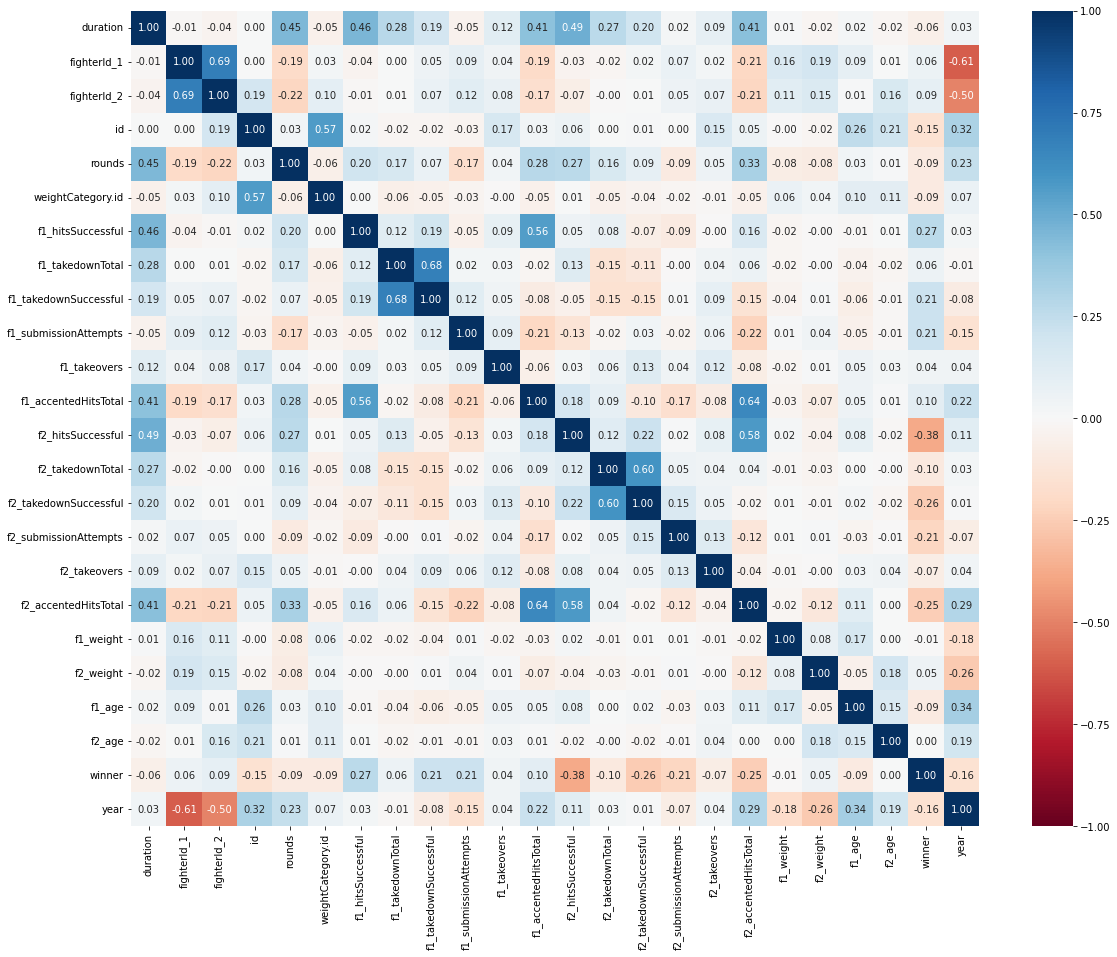

In [103]:
# Check for collinearity between variables
corr = final_df.corr()

display(corr)
plt.figure(figsize=(19, 15))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, fmt='.2f', vmin=-1.0);

In [104]:
X_train = df_train.drop(columns=["winner"])
y_train = df_train["winner"]

X_valid = df_valid.drop(columns=["winner"])
y_valid = df_valid["winner"]

X_test = df_test.drop(columns=["winner"])
y_test = df_test["winner"]

In [105]:
clf = CatBoostClassifier(iterations=1000, 
                           depth=4,
                           learning_rate=0.01,
                           loss_function='Logloss',
                           colsample_bylevel=1,
                           subsample=0.5,
#                                    bagging_temperature=bagging_temperature,
                           random_strength=1,
                           l2_leaf_reg=30,
                           eval_metric='Accuracy',
#                            boosting_type='Plain', # 'Plain'
                           bootstrap_type='Bernoulli',# 'Bernoulli' Bayesian
                           max_ctr_complexity=2,
                           task_type='GPU',
                          )

clf.fit(X_train, y_train, plot=True, eval_set=(X_valid, y_valid), verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [106]:
y_pred = clf.predict(df_test)
df_test['y_pred'] = y_pred
df_test

,duration,eventDate.date,fighterId_1,fighterId_2,id,rounds,weightCategory.id,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f1_weight,f2_weight,f1_age,f2_age,winner,year,y_pred
6420,40.0,2020-01-18,211,347,39796,1.0,14,20.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,1.0,70.31,61.24,34.0,29.0,True,2020,True
6421,106.0,2020-01-18,292,404,39804,2.0,14,4.0,0.0,0.0,0.0,0.0,4.0,10.0,2.0,1.0,1.0,0.0,9.0,65.77,83.91,30.0,35.0,False,2020,False
6422,300.0,2020-01-18,427,562,39805,3.0,14,32.0,1.0,0.0,0.0,0.0,17.0,28.0,0.0,0.0,0.0,0.0,27.0,70.31,65.77,34.0,28.0,True,2020,False
6423,300.0,2020-01-18,407,521,39807,3.0,14,20.0,1.0,0.0,0.0,0.0,69.0,16.0,0.0,0.0,0.0,0.0,49.0,120.20,61.24,31.0,27.0,False,2020,True
6424,300.0,2020-01-18,233,525,39820,3.0,14,41.0,0.0,0.0,0.0,1.0,10.0,6.0,0.0,0.0,0.0,1.0,7.0,65.77,77.11,31.0,32.0,True,2020,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6990,300.0,2020-12-19,89,3537,40358,3.0,5,NaN,NaN,NaN,NaN,NaN,NaN,20.0,0.0,0.0,0.0,0.0,55.0,112.94,77.11,28.0,32.0,False,2020,False
6991,300.0,2020-12-19,2962,3564,40359,3.0,7,6.0,0.0,0.0,0.0,0.0,21.0,62.0,1.0,0.0,0.0,1.0,60.0,77.11,92.99,33.0,28.0,False,2020,False
6992,300.0,2020-12-19,244,292,40383,3.0,6,15.0,2.0,0.0,0.0,0.0,8.0,39.0,0.0,0.0,0.0,3.0,15.0,56.70,65.77,35.0,30.0,False,2020,False
6993,300.0,2020-12-19,633,645,40387,3.0,11,31.0,0.0,0.0,0.0,4.0,17.0,10.0,1.0,0.0,1.0,0.0,2.0,52.16,56.70,28.0,33.0,True,2020,True


In [107]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

In [108]:
df_test['y_pred'].unique()

array(['True', 'False'], dtype=object)

In [109]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527 entries, 6420 to 6994
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   duration               432 non-null    float64       
 1   eventDate.date         527 non-null    datetime64[ns]
 2   fighterId_1            527 non-null    int64         
 3   fighterId_2            527 non-null    int64         
 4   id                     527 non-null    int64         
 5   rounds                 432 non-null    float64       
 6   weightCategory.id      527 non-null    int64         
 7   f1_hitsSuccessful      410 non-null    float64       
 8   f1_takedownTotal       410 non-null    float64       
 9   f1_takedownSuccessful  410 non-null    float64       
 10  f1_submissionAttempts  410 non-null    float64       
 11  f1_takeovers           410 non-null    float64       
 12  f1_accentedHitsTotal   410 non-null    float64       
 13  f

In [110]:
y_pred = np.apply_along_axis(lambda x : x == "True", 0, y_pred)

In [111]:
# Точность модели CatBoostClassifie
f1_score(y_test, y_pred)


0.7169811320754716

# Пробуем модель RandomForestClassifier

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.pipeline import Pipeline

rfc = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=10,  min_samples_split=2,
                             min_samples_leaf=1, random_state=0)


dataset_train = df_train.drop(columns=['eventDate.date'])
dataset_valid = df_valid.drop(columns=['eventDate.date'])

dataset_train = dataset_train.dropna()
dataset_valid = dataset_valid.dropna()

X_new_train = dataset_train.drop(columns=['winner'])
y_new_train = dataset_train['winner']

X_new_valid = dataset_valid.drop(columns=['winner'])
y_new_valid = dataset_valid['winner']

model = Pipeline([ ('random_forest', rfc)])
model.fit(X_new_train, y_new_train)
y_pred_forest = model.predict(X_new_valid )

metrics.accuracy_score(y_new_valid, y_pred_forest)

0.7603960396039604